In [1]:
"""
Prediction file: Based on the trained neural network,see the performace on the testing set
Mapping Seed-> Sim (Fig 2)

General workflow
Load test data->Load trained dilResNet model and predict the output(are in latent representation) on test set-> 
Decode into higher dimensional representation using SD VAE-> Display 


"""

'\nPrediction file: Based on the trained neural network,see the performace on the testing set\nMapping Seed-> Sim (Fig 2)\n\nGeneral workflow\nLoad test data->Load trained dilResNet model and predict the output(are in latent representation) on test set-> \nDecode into higher dimensional representation using SD VAE-> Display \n\n\n'

In [2]:
# import libraries 

import os
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
from diffusers import AutoencoderKL
from PIL import Image
from skimage.metrics import structural_similarity as ssim
import time


/hpc/dctrl/ks723/miniconda3/envs/pytorch_PA_patternprediction/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-08-06 17:33:04,541] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [3]:
# prediction from testing dataset

'''
Loading test data for model testing

'''

rfactor=256

img_length=rfactor
img_width=rfactor

# for CentOS 8 cluster 
datadir_i2='/hpc/group/youlab/ks723/storage/MATLAB_SIMS/Sim_050924/Sim_input/intermediate/Tp3'
datadir_o2="/hpc/group/youlab/ks723/storage/MATLAB_SIMS/Sim_050924/Sim_output"

path_i2=os.path.join(datadir_i2)
path_o2=os.path.join(datadir_o2)

ground_truth_data=[]
input_data=[]

# parameters for image

img_shape_i=256  # to make image 256x256 after cropping the image
img_shape_o=32   # to make image 32x32 after cropping the image 


# parameters for cropping output of sim hardcoded
top_crop_i = 30
bottom_crop_i = 30
left_crop_i = 31
right_crop_i = 30



# do training with the next 10k images. load previous training point 
def create_ground_truth_data(top_crop, bottom_crop, left_crop, right_crop, start_index, end_index,path_i):
    count = 0
    img_filenames_i = sorted(os.listdir(path_i))

    # Ensure end_index does not exceed the number of available images
    end_index = min(end_index, len(img_filenames_i))

    for img in img_filenames_i[start_index:end_index]:
        img_array_i = cv2.imread(os.path.join(path_i, img), cv2.IMREAD_GRAYSCALE)

        new_height = img_array_i.shape[0] - (top_crop + bottom_crop)
        new_width = img_array_i.shape[1] - (left_crop + right_crop)

        new_array_i = img_array_i[top_crop:top_crop + new_height, left_crop:left_crop + new_width]

        new_array_i = cv2.resize(new_array_i, (img_length, img_width))

        ground_truth_data.append([new_array_i])
        count = count + 1
        if count >= (end_index - start_index):
            break


## add some of the images from the main dataset that hasn't been used to train the network 

start_index = 70000  
end_index = 70100 
create_ground_truth_data(top_crop_i, bottom_crop_i, left_crop_i, right_crop_i, start_index, end_index,path_i2)

top_crop_o=0
bottom_crop_o=0
left_crop_o=3
right_crop_o=2

def create_input_data(top_crop,bottom_crop,left_crop,right_crop, start_index, end_index,path_o):
    
    count=0

    img_filenames_o = sorted(os.listdir(path_o))
    # Ensure end_index does not exceed the number of available images
    end_index = min(end_index, len(img_filenames_o))
    
    for img in img_filenames_o[start_index:end_index]:
        img_array_o=cv2.imread(os.path.join(path_o,img),cv2.IMREAD_GRAYSCALE)

        new_height = img_array_o.shape[0] - (top_crop + bottom_crop)
        new_width = img_array_o.shape[1] - (left_crop + right_crop)
        new_array_o = img_array_o[top_crop:top_crop+new_height, left_crop:left_crop+new_width]

      
        (T, new_array_o) = cv2.threshold(new_array_o, 0, 255,cv2.THRESH_BINARY| cv2.THRESH_OTSU)

        input_data.append([new_array_o])
        count=count+1
        if count >= (end_index - start_index):
            break


start_index = 70000  
end_index = 70100 
create_input_data(top_crop_o, bottom_crop_o, left_crop_o, right_crop_o, start_index, end_index,path_o2)


X=ground_truth_data  
y=input_data

X=(np.array(X).reshape(-1,1,img_shape_i,img_shape_i)) #/255.0  # last one is grayscale first minus one is all x
y=(np.array(y).reshape(-1,1,img_shape_o,img_shape_o)) #/255.0

# normalizing images here to be bw 0 and 1 

X=X/255.0 
y=y/255.0
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Convert numpy arrays to torch tensors
X = torch.Tensor(X)
y = torch.Tensor(y)


y3=y.repeat(1, 3, 1, 1)
y4=y.repeat(1, 4, 1, 1)


In [4]:
'''
Defining dilResNet model for loading model weights
'''
# Dilated Basic Block similar to PDEArena
class PDEArenaDilatedBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dilation_rates, activation=nn.ReLU, norm=True):
        super(PDEArenaDilatedBlock, self).__init__()

        # Create dilated convolution layers with specified dilation rates
        self.dilated_layers = nn.ModuleList([
            nn.Conv2d(
                in_planes if i == 0 else out_planes, 
                out_planes, 
                kernel_size=3, 
                padding=rate, 
                dilation=rate, 
                bias=False
            )
            for i, rate in enumerate(dilation_rates)
        ])
        
        # Normalization and Activation layers
        self.norm_layers = nn.ModuleList([nn.BatchNorm2d(out_planes) if norm else nn.Identity() for _ in dilation_rates])
        self.activation = activation(inplace=True)

        # Shortcut (1x1 convolution if input and output planes differ)
        self.shortcut = nn.Sequential()
        if in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_planes) if norm else nn.Identity()
            )

    def forward(self, x):
        out = x
        for layer, norm in zip(self.dilated_layers, self.norm_layers):
            out = self.activation(norm(layer(out)))
        return out + self.shortcut(x)  # Residual connection

# Dilated ResNet with Adjustable Layers and Blocks
class PDEArenaDilatedResNet(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=64, num_blocks=15, dilation_rates=[1, 2, 4, 8], activation=nn.ReLU, norm=True):
        super(PDEArenaDilatedResNet, self).__init__()
        
        self.in_conv = nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1)  # Input layer
        
        # Stack of dilated blocks
        self.layers = nn.Sequential(
            *[PDEArenaDilatedBlock(hidden_channels, hidden_channels, dilation_rates, activation=activation, norm=norm) for _ in range(num_blocks)]
        )
        
        self.out_conv = nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1)  # Output layer

    def forward(self, x):
        x = self.in_conv(x)
        x = self.layers(x)
        return self.out_conv(x)


model = PDEArenaDilatedResNet(
    in_channels=3,               # Input channels
    out_channels=4,              # Output channels 
    hidden_channels=64,          # Number of hidden channels
    num_blocks=15,               # Number of dilated blocks 
    dilation_rates=[1, 2, 4, 8], # Dilation rates for multi-scale feature capture
    activation=nn.ReLU,          # Activation function
    norm=True                    # Use BatchNorm after each convolution
)


In [5]:
'''
Define pre-trained SD VAE for decoding orginal predicted patterns from the latent predicted patterns
dilResnet will predict latent representation of patterns 

'''

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

device=torch.device("cpu")

# first load the VAE

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

vae.to(device)

def encode_img(input_img):
    input_img = input_img.repeat(3, 1, 1)
    
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    if len(input_img.shape)<4:
        input_img = input_img.unsqueeze(0)
    with torch.no_grad():
        latent = vae.encode(input_img*2 - 1) # Note scaling  # to make outputs from -1 to 1 
    return 0.18215 * latent.latent_dist.sample()    



def decode_img(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)    # to make outputs from 0 to 1 
    image = image.detach()
    return image



NAME='Pixel_32x32x3to32x32x4_dilRESNET_30k_newpatterns_seedtointermediate__Model_v1113_Cluster_GPU_tfData-1731542355'
model.load_state_dict(torch.load(f'/hpc/group/youlab/ks723/miniconda3/saved_models/trained/{NAME}.pt'))
model.to(device)

model.eval()

start_time=time.perf_counter()
batch_size=64



with torch.no_grad():
    for i in range(0, len(y3), batch_size):
        batch = y3[i:i+batch_size].to(device) 
        predicted_latents=model(batch)  #y3 is the input seed with 3 channels for the UNET 

end_time=time.perf_counter()

print(f"Prediction time: {end_time - start_time:.4f} seconds")



# predicted_latents_rescaled=predicted_latents

# # use the vae decoder to convert the encoded images to final patterns

# pred_images=decode_img(predicted_latents_rescaled)


# '''
# Functions for displaying seed, actual simulation and predicted simulation
# '''
# # for generation see first row seed, second row final patterns(ground truth), third row generated patterns( predicted output)


# def tensor_to_pil_v2(tensor):
#     tensor = tensor.permute(1, 2, 0)  # Convert to (height, width, channels)
#     img = (tensor.cpu().numpy() * 255).astype('uint8')
#     return Image.fromarray(img.squeeze())

# def display_predicted_images(input_seed,final_patterns,pred_images, num_samples):
   
#     plt.figure(figsize=(6*num_samples/3,6))
#     plt.subplots_adjust(wspace=0.01, hspace=0.01)

#     for i in range(num_samples):

#         image_i=tensor_to_pil_v2(input_seed[i,:,:,:])
#         image_o=tensor_to_pil_v2(final_patterns[i,:,:,:])
#         image_p= tensor_to_pil_v2(pred_images[i,:,:,:].to("cpu"))
        
#         ax = plt.subplot(3, num_samples, i + 1)

#         plt.imshow(image_i)
#         plt.gray()
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)

#         ax = plt.subplot(3, num_samples, i + 1+num_samples)

#         plt.imshow(image_p,cmap="gray")
        
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)
#         print(np.array(image_p).shape)
    

#         ax=plt.subplot(3, num_samples, i + 1+ num_samples+ num_samples)

        
#         plt.imshow(image_o)
#         plt.gray()
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)

#     plt.show()

# selected_indices=[4,5,2,10,14] 
# # Display samples from train dataset
# display_predicted_images(y3[selected_indices,:,:,:],X[selected_indices,:,:,:], pred_images[selected_indices,:,:,:] ,len(selected_indices))   # 

/hpc/dctrl/ks723/miniconda3/envs/pytorch_PA_patternprediction/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Prediction time: 7.8950 seconds


In [6]:
y3.shape

torch.Size([100, 3, 32, 32])

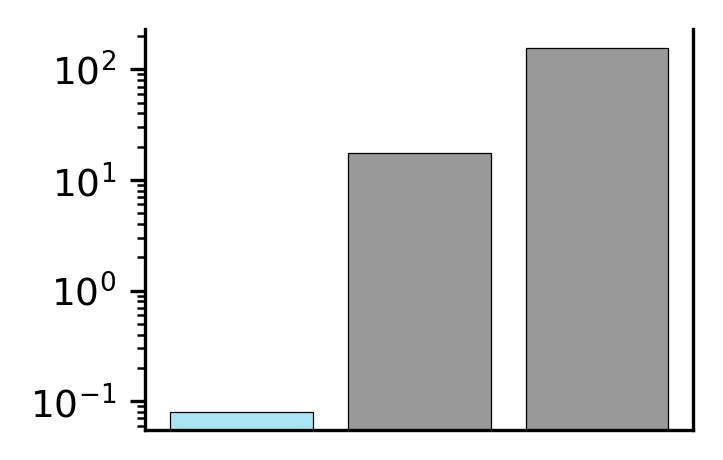

In [16]:
# plot the benchmarking graph 

# for 100 images, the time for prediction using GPU is 0.15s, and using CPU is 8.0s->100 times slower

# Prediction with trained ML model, using CPU + generation of MATLAB scripts 

# Parallel total time: 29 min for 100 images. (times from email slurm jobs) 
# Serial total time: 04 hours, 22 min for 100 images. (times from email slurm jobs)

#for A4 size
height_figure= 4.404 /2.54 # in inches
width_figure= 5.985 /2.54 # in inches
fig,ax=plt.subplots(1,1,figsize=(width_figure,height_figure),dpi=300) # A4 size in inches

times=[8/100,29*60/100,(4*60+22)*60/100] # in seconds
labels=['ML surrogate','PDE Simulation(Parallel computing)','PDE simulation']


bar_colors=['#a6e7f2fa','#707070b5','#707070b5']
ax.bar(labels,times,color=bar_colors,edgecolor='black',linewidth=0.3)
ax.set_yscale("log")
ax.tick_params(axis='y', labelsize=9)
# hide the x ticks
ax.set_xticks([])
# remove the top border
ax.spines['top'].set_visible(False)

# ax.tick_params(axis='x', labelsize=15)
# ax.set_ylabel('Time (seconds)',fontsize=20)
plt.show()